<a href="https://colab.research.google.com/github/LoPA607/AIDS_248/blob/main/OSASIS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio diffusers transformers accelerate pillow tqdm huggingface_hub --quiet


In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, models
from PIL import Image
from diffusers import AutoencoderKL
from transformers import CLIPModel, CLIPProcessor
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
def load_image(path, size=512):
    img = Image.open(path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0).to(device)

def show(img_tensor, title="Image"):
    img = img_tensor.detach().cpu().squeeze(0).permute(1,2,0).clamp(0,1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device).eval()
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device).eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:21].to(device).eval()
for p in vgg.parameters():
    p.requires_grad = False


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 76.2MB/s]


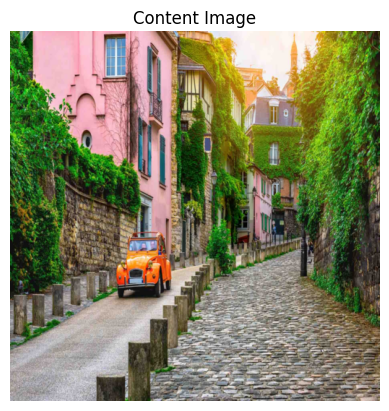

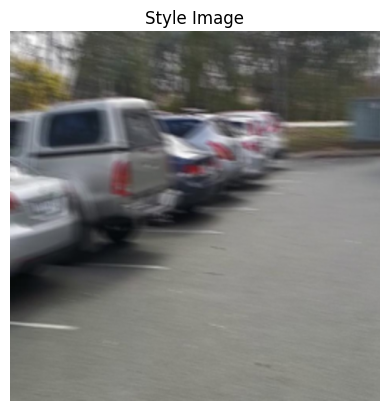

In [ ]:
content_path = "/content/drive/MyDrive/IE643/Project/content.jpg"
style_path   = "/content/drive/MyDrive/IE643/Project/style.png"

content_img = load_image(content_path)
style_img = load_image(style_path)

show(content_img, "Content Image")
show(style_img, "Style Image")


In [ ]:
def encode_vae(img):
    with torch.no_grad():
        latent = vae.encode(img * 2 - 1).latent_dist.sample()
        latent = latent * 0.18215
    return latent
def decode_vae(latent):
    latent = latent / 0.18215
    # Do NOT use torch.no_grad here, VAE parameters are frozen anyway
    img = vae.decode(latent).sample
    return (img + 1) / 2


z_content = encode_vae(content_img)
z_style = encode_vae(style_img)

In [ ]:
def perceptual_loss(x, y):
    return F.mse_loss(vgg(x), vgg(y))

def edge_loss(x, y):
    x_gray = x.mean(dim=1, keepdim=True)
    y_gray = y.mean(dim=1, keepdim=True)

    sobel_x = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], device=device, dtype=torch.float32).view(1,1,3,3)
    sobel_y = sobel_x.transpose(2,3)

    gx = F.conv2d(x_gray, sobel_x, padding=1)
    gy = F.conv2d(x_gray, sobel_y, padding=1)
    gx2 = F.conv2d(y_gray, sobel_x, padding=1)
    gy2 = F.conv2d(y_gray, sobel_y, padding=1)

    return F.l1_loss(gx, gx2) + F.l1_loss(gy, gy2)

def clip_embed(img):
    img_pil = transforms.ToPILImage()(img.squeeze(0).cpu())
    inputs = clip_processor(images=img_pil, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = clip_model.get_image_features(**inputs)
    return emb / emb.norm()


In [ ]:
class StyleGenerator(nn.Module):
    def __init__(self, latent_dim=4, style_dim=768):
        super().__init__()
        self.fc_style = nn.Linear(style_dim, 512)
        self.conv = nn.Sequential(
            nn.Conv2d(latent_dim+512, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, latent_dim, 3, padding=1)
        )
    def forward(self, z, style_emb):
        style_map = self.fc_style(style_emb).unsqueeze(-1).unsqueeze(-1)
        style_map = style_map.expand(-1, -1, z.shape[2], z.shape[3])
        z_in = torch.cat([z, style_map], dim=1)
        return self.conv(z_in)


In [ ]:
gen = StyleGenerator().to(device)
optimizer = optim.Adam(gen.parameters(), lr=0.01)

for step in tqdm(range(600)):
    z_gen = gen(z_content, style_emb)           # requires grad
    z_out = z_content + 0.05 * z_gen           # small residual
    z_out = torch.clamp(z_out, -3, 3)          # keep latent in range

    img_out = decode_vae(z_out)                # gradients can flow to generator

    # losses
    c_loss = perceptual_loss(img_out, content_img)
    e_loss = edge_loss(img_out, content_img)
    s_loss = 1 - F.cosine_similarity(clip_embed(img_out), style_emb).mean()

    loss = 1.0 * c_loss + 0.5 * e_loss + 1.0 * s_loss

    optimizer.zero_grad()
    loss.backward()                             # now generator gets gradients
    optimizer.step()


100%|██████████| 600/600 [14:13<00:00,  1.42s/it]


In [ ]:
# Make sure no gradients are needed for final generation
with torch.no_grad():
    # Generator output (small residual)
    z_final = z_content + 0.05 * gen(z_content, style_emb)
    z_final = torch.clamp(z_final, -3, 3)  # keep latent in valid range

    # Decode to RGB image using frozen VAE
    stylized_img = decode_vae(z_final)


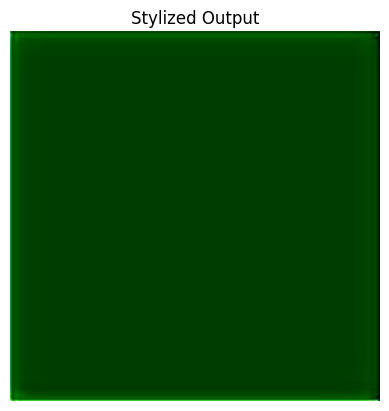

In [ ]:
def show(img_tensor, title="Image"):
    img = img_tensor.detach().cpu().squeeze(0).permute(1,2,0).clamp(0,1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

show(stylized_img, "Stylized Output")
